In [ ]:
import pandas as pd
import os
import numpy as np
import wandb

# Train model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
import os

# 1. Mounting Google Drive: This allows Colab to access files in your Google Drive
drive.mount('/content/drive')
basedir = "/content/drive/MyDrive/cs6365/"

Mounted at /content/drive


In [ ]:
df21 = pd.read_csv('/content/drive/MyDrive/cs6365/merged_gw_2021_22.csv')
df22 = pd.read_csv('/content/drive/MyDrive/cs6365/merged_gw_2022_23.csv')
df23 = pd.read_csv('/content/drive/MyDrive/cs6365/merged_gw_2023_24.csv')

In [ ]:
class FplDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)


- Prepare df21 data as "training" data

In [ ]:
# Dropping unnecessary columns
train_df = df21.drop(["name", "team", "position", "fixture", "kickoff_time", "opponent_team", "round", "transfers_balance"], axis=1)

# Create a column for ground truth
ground_truth = df21.loc[:, ["was_home", "total_points", "element", "GW"]]

# total points for GW 2 becomes the ground truth for GW 1
ground_truth['GW'] -= 1
ground_truth = ground_truth.rename(columns={"total_points":"y", "was_home":"is_home"})

# inner join with train df
train_df = train_df.merge(ground_truth, how="inner", on=["element", "GW"])

# Dropping 'element' and 'gw' columns as they are no longer needed
train_df = train_df.drop(["element", "GW"], axis=1)
train_df

,xP,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,team_h_score,threat,total_points,transfers_in,transfers_out,value,was_home,yellow_cards,is_home,y
0,0.0,0,0,0,0,0.0,0,0,0.0,0.0,...,5,0.0,0,0,0,50,True,0,False,0
1,0.4,0,0,0,0,0.0,0,0,0.0,0.0,...,3,0.0,0,0,0,45,False,0,True,0
2,0.0,0,0,0,0,0.0,0,0,0.0,0.0,...,3,0.0,0,0,0,45,True,0,False,0
3,2.3,0,0,20,0,30.5,3,0,5.2,21.6,...,3,0.0,2,0,0,65,False,0,True,2
4,4.4,0,3,61,0,35.9,1,3,20.1,106.2,...,5,59.0,20,0,0,120,True,0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25091,0.0,0,0,0,0,0.0,0,0,0.0,0.0,...,2,0.0,0,0,30,44,False,0,True,0
25092,1.5,0,0,0,0,0.0,0,0,0.0,0.0,...,1,0.0,0,693,19407,49,False,0,True,0
25093,1.5,0,0,12,0,20.5,1,0,4.0,17.4,...,1,2.0,2,693,19407,49,False,0,True,0
25094,-1.5,0,0,0,0,0.0,0,0,0.0,0.0,...,1,0.0,0,543,417,39,False,0,True,0


In [ ]:
#Pre-processing

# Dropping columns not present in API
train_df = train_df.drop(['xP', 'selected', 'team_a_score', 'team_h_score', 'value', 'was_home'], axis=1)
train_df = train_df.astype(np.float32)
train_df

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,...,penalties_saved,red_cards,saves,threat,total_points,transfers_in,transfers_out,yellow_cards,is_home,y
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,20.0,0.0,30.500000,3.0,0.0,5.2,21.600000,90.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0
4,0.0,3.0,61.0,0.0,35.900002,1.0,3.0,20.1,106.199997,90.0,...,0.0,0.0,0.0,59.0,20.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25091,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,1.0,0.0
25092,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,693.0,19407.0,0.0,1.0,0.0
25093,0.0,0.0,12.0,0.0,20.500000,1.0,0.0,4.0,17.400000,90.0,...,0.0,0.0,0.0,2.0,2.0,693.0,19407.0,0.0,1.0,0.0
25094,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,543.0,417.0,0.0,1.0,0.0


In [ ]:
# Convert data to PyTorch Dataset and DataLoader
inputs_train = train_df.drop('y', axis=1).to_numpy()
# num_features = inputs.shape[1]
targets_train = train_df.loc[:,"y"].to_numpy().reshape(-1,1)
# dataset = FplDataset(inputs, targets)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

- Prepare 22/23 as test data

In [ ]:
# Dropping unnecessary columns
test_df = df22.drop(["name", "team", "position", "fixture", "kickoff_time", "opponent_team", "round", "transfers_balance"], axis=1)

# Create a column for ground truth
ground_truth = df22.loc[:, ["was_home", "total_points", "element", "GW"]]

# total points for GW 2 becomes the ground truth for GW 1
ground_truth['GW'] -= 1
ground_truth = ground_truth.rename(columns={"total_points":"y", "was_home":"is_home"})

# inner join with train df
test_df = test_df.merge(ground_truth, how="inner", on=["element", "GW"])

# Dropping 'element' columns as they are no longer needed
test_df = test_df.drop(["element"], axis=1)
test_df

,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,...,threat,total_points,transfers_in,transfers_out,value,was_home,yellow_cards,GW,is_home,y
0,1.5,0,0,3,0,0.0,0.0,0.0,0.0,0.00,...,0.0,1,0,0,55,False,0,1,True,0
1,1.1,0,0,3,0,0.0,0.0,0.0,0.0,0.00,...,0.0,1,0,0,50,True,0,1,False,1
2,2.0,0,0,3,0,0.3,0.0,0.0,0.0,0.00,...,19.0,1,0,0,55,False,0,1,True,1
3,2.4,0,3,43,1,14.6,0.0,0.0,0.0,0.00,...,25.0,15,0,0,45,True,0,1,False,5
4,1.9,0,0,15,0,1.3,0.0,0.0,0.0,0.00,...,0.0,1,0,0,45,True,0,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25928,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.00,...,0.0,0,13,255,44,True,0,37,False,0
25929,0.7,0,0,5,0,0.0,0.0,0.0,0.0,0.53,...,2.0,0,1820,5279,43,False,1,37,True,0
25930,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.00,...,0.0,0,9,29,45,True,0,37,False,0
25931,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.00,...,0.0,0,9,29,45,True,0,37,False,0


In [ ]:
#Pre-processing

# Dropping columns not present in API
test_df = test_df.drop(['xP', 'selected', 'team_a_score', 'team_h_score', 'value', 'was_home'], axis=1)
test_df = test_df.astype(np.float32)
test_df

,assists,bonus,bps,clean_sheets,creativity,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,goals_conceded,...,saves,starts,threat,total_points,transfers_in,transfers_out,yellow_cards,GW,is_home,y
0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,3.0,0.0,0.3,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,19.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,3.0,43.0,1.0,14.6,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,25.0,15.0,0.0,0.0,0.0,1.0,0.0,5.0
4,0.0,0.0,15.0,0.0,1.3,0.0,0.0,0.0,0.00,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,13.0,255.0,0.0,37.0,0.0,0.0
25929,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.53,1.0,...,0.0,0.0,2.0,0.0,1820.0,5279.0,1.0,37.0,1.0,0.0
25930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,9.0,29.0,0.0,37.0,0.0,0.0
25931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,9.0,29.0,0.0,37.0,0.0,0.0


In [ ]:
# Keeping only required test columns
stats = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'saves', 'threat', 'total_points', 'transfers_in', 'transfers_out',
       'yellow_cards', 'is_home']

test_df = test_df[stats + ['y', "GW"]]
test_df

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,...,red_cards,saves,threat,total_points,transfers_in,transfers_out,yellow_cards,is_home,y,GW
0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,3.0,0.0,0.3,0.0,0.0,2.5,5.2,15.0,...,0.0,0.0,19.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,3.0,43.0,1.0,14.6,0.0,1.0,10.6,66.0,90.0,...,0.0,0.0,25.0,15.0,0.0,0.0,0.0,0.0,5.0,1.0
4,0.0,0.0,15.0,0.0,1.3,2.0,0.0,1.5,14.0,90.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.0,255.0,0.0,0.0,0.0,37.0
25929,0.0,0.0,5.0,0.0,0.0,1.0,0.0,1.3,11.0,37.0,...,0.0,0.0,2.0,0.0,1820.0,5279.0,1.0,1.0,0.0,37.0
25930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,29.0,0.0,0.0,0.0,37.0
25931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,29.0,0.0,0.0,0.0,37.0


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        residual = x
        out = self.fc1(self.norm1(x))
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(self.norm2(out))
        return self.activation(out + residual)


# Define a better model
class FplModel(nn.Module):
    def __init__(self, num_features, output_dim=1, hidden_dim=128, num_blocks=3, dropout=0.1):
        super(FplModel, self).__init__()
        self.input_layer = nn.Linear(num_features, hidden_dim)
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        return self.output_layer(x)

# Initialize the model, loss function, and optimizer
# model = FplModel(num_features, num_blocks=num_blocks)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
# optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=

In [ ]:
# define hyperparameters
num_epochs = 70
lr = 5e-6
weight_decay = 1e-2

# Load model
num_features = 21
model = FplModel(num_features)
model.load_state_dict(torch.load('/content/drive/MyDrive/cs6365/residual-2.pth'))
model.eval()

FplModel(
  (input_layer): Linear(in_features=21, out_features=128, bias=True)
  (blocks): Sequential(
    (0): ResidualBlock(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (1): ResidualBlock(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (2): ResidualBlock(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (fc2): 

In [ ]:
# Get accuracy for testing df per gameweek
loss_over_gameweeks = []
for gw in range(1,38):
  playerData = test_df.loc[test_df["GW"] == gw, :].drop(["GW", "y"], axis=1).to_numpy()
  playerData = torch.tensor(playerData, dtype=torch.float32)
  with torch.no_grad():  # Disables gradient calculation for inference
      predictions = model(playerData)
  targets_batch = test_df.loc[test_df["GW"] == gw, "y"].to_numpy().reshape(-1,1)
  targets_batch = torch.tensor(targets_batch, dtype=torch.float32)
  loss = criterion(predictions, targets_batch)
  if loss.isnan():
    loss_over_gameweeks.append(loss_over_gameweeks[-1])
  else:
    loss_over_gameweeks.append(loss.item())

In [ ]:
# Get accuracy for testing df per gameweek, training at 10,20,30
loss_over_gameweeks_3 = []
train_at = [10,20,30]
def get_prev(i):
  if i == 10:
    return 0
  elif i == 20:
    return 11
  elif i == 30:
    return 21
  else:
    assert False

for gw in range(1,38):

  if gw in train_at:
    # Training loop
    model = FplModel(num_features)
    # model.load_state_dict(torch.load('/content/drive/MyDrive/cs6365/residual-1.pth'))
    model.train()
    num_epochs = 50
    # Convert data to PyTorch Dataset and DataLoader
    inputs = test_df.loc[test_df["GW"] < gw, :].drop(['y','GW'], axis=1).to_numpy()
    # print(inputs.shape)
    # num_features = inputs.shape[1]
    # print("Num features", num_features)
    targets = test_df.loc[test_df["GW"] < gw, "y"].to_numpy().reshape(-1,1)
    total_input = np.concat((inputs_train, inputs), axis=0)
    total_target = np.concat((targets_train, targets), axis=0)
    dataset = FplDataset(total_input, total_target)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # model = FplModel(num_features)
    criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for inputs_batch, targets_batch in dataloader:
            # Forward pass
            outputs = model(inputs_batch)
            loss = criterion(outputs, targets_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
    print(f"model trained for {gw}")
    model.eval()
        # run.log({'avg_loss': avg_loss})
        # if (epoch+1) % 5 == 0:
        #   print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


  playerData = test_df.loc[test_df["GW"] == gw, :].drop(["GW", "y"], axis=1).to_numpy()
  playerData = torch.tensor(playerData, dtype=torch.float32)
  with torch.no_grad():  # Disables gradient calculation for inference
      predictions = model(playerData)
  targets_batch = test_df.loc[test_df["GW"] == gw, "y"].to_numpy().reshape(-1,1)
  targets_batch = torch.tensor(targets_batch, dtype=torch.float32)
  loss = criterion(predictions, targets_batch)
  if loss.isnan():
    loss_over_gameweeks_3.append(loss_over_gameweeks_3[-1])
  else:
    loss_over_gameweeks_3.append(loss.item())
# loss_over_gameweeks

model trained for 10
model trained for 20
model trained for 30


In [ ]:
# Load model again
num_features = 21
model = FplModel(num_features)
model.load_state_dict(torch.load('/content/drive/MyDrive/cs6365/residual-2.pth'))
model.eval()

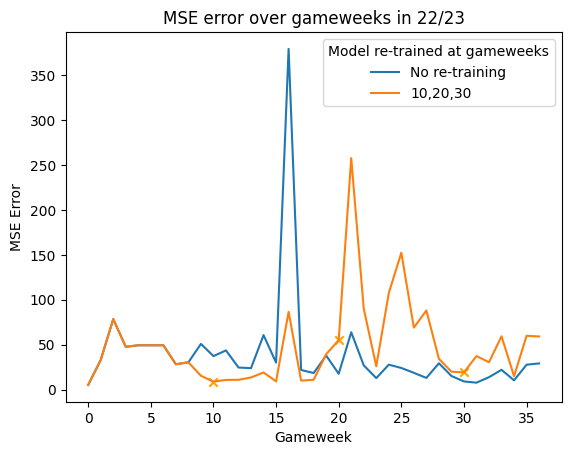

In [ ]:
import matplotlib.pyplot as plt

# Example data
list1 = loss_over_gameweeks
list2 = loss_over_gameweeks_3
# list3 = [0]*37
# list2 = list3

# Plot each list
plt.plot(list1, label='No re-training')
plt.plot(list2, label='10,20,30')
# plt.plot(list3, label='7,14,21,28,35')

# Plot times of re-training
plt.scatter([10,20,30], [list2[i] for i in [10,20,30]], color='orange', marker='x')
# plt.scatter([7,14,21,28,35], [list3[i] for i in [7,14,21,28,35]], color='green', marker='x')

# Add labels and legend
plt.xlabel('Gameweek')
plt.ylabel('MSE Error')
plt.title('MSE error over gameweeks in 22/23')
plt.legend(title="Model re-trained at gameweeks")

# Show the plot
plt.show()

- Train a model on 21/22 and test on 22/23

In [ ]:
# Dropping unnecessary columns
train_df = df22.drop(["name", "team", "position", "fixture", "kickoff_time", "opponent_team", "round", "transfers_balance"], axis=1)

# Create a column for ground truth
ground_truth = df22.loc[:, ["was_home", "total_points", "element", "GW"]]

# total points for GW 2 becomes the ground truth for GW 1
ground_truth['GW'] -= 1
ground_truth = ground_truth.rename(columns={"total_points":"y", "was_home":"is_home"})

# inner join with train df
train_df = train_df.merge(ground_truth, how="inner", on=["element", "GW"])

# Dropping 'element' and 'gw' columns as they are no longer needed
train_df = train_df.drop(["element", "GW"], axis=1)

# Dropping columns not present in API
train_df = train_df.drop(['xP', 'selected', 'team_a_score', 'team_h_score', 'value', 'was_home'], axis=1)
train_df = train_df.astype(np.float32)
train_df

,assists,bonus,bps,clean_sheets,creativity,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,goals_conceded,...,red_cards,saves,starts,threat,total_points,transfers_in,transfers_out,yellow_cards,is_home,y
0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,3.0,0.0,0.3,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,19.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,3.0,43.0,1.0,14.6,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,25.0,15.0,0.0,0.0,0.0,0.0,5.0
4,0.0,0.0,15.0,0.0,1.3,0.0,0.0,0.0,0.00,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,13.0,255.0,0.0,0.0,0.0
25929,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.53,1.0,...,0.0,0.0,0.0,2.0,0.0,1820.0,5279.0,1.0,1.0,0.0
25930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,29.0,0.0,0.0,0.0
25931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,29.0,0.0,0.0,0.0


In [ ]:
# Set experiment hyperparameters
num_epochs = 50
lr = 5e-6
weight_decay = 1e-2
num_blocks = 3 # Number of residual blocks in the model

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="aamirmd-georgia-institute-of-technology",
    # Set the wandb project where this run will be logged.
    project="cs6365-fpl-model",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": lr,
        "architecture": "ResidualModel",
        "epochs": num_epochs,
        "weight_decay": weight_decay,
        "number of residual blocks": num_blocks
    },
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aamirmd (aamirmd-georgia-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        residual = x
        out = self.fc1(self.norm1(x))
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(self.norm2(out))
        return self.activation(out + residual)


# Define a better model
class FplModel(nn.Module):
    def __init__(self, num_features, output_dim=1, hidden_dim=128, num_blocks=3, dropout=0.1):
        super(FplModel, self).__init__()
        self.input_layer = nn.Linear(num_features, hidden_dim)
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        return self.output_layer(x)

# Initialize the model, loss function, and optimizer
model = FplModel(num_features, num_blocks=num_blocks)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
# Training loop
model.train()  # Set model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs_batch, targets_batch in dataloader:
        # Forward pass
        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    run.log({'avg_loss': avg_loss})
    if (epoch+1) % 5 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

run.finish()

Epoch [5/50], Loss: 5617.1226
Epoch [10/50], Loss: 434.2702
Epoch [15/50], Loss: 195.8974
Epoch [20/50], Loss: 127.6323
Epoch [25/50], Loss: 105.7254
Epoch [30/50], Loss: 68.2821
Epoch [35/50], Loss: 86.3236
Epoch [40/50], Loss: 60.0757
Epoch [45/50], Loss: 51.7973
Epoch [50/50], Loss: 46.6805


avg_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,46.68049


In [ ]:
# Dropping unnecessary columns
test_df = df23.drop(["name", "team", "position", "fixture", "kickoff_time", "opponent_team", "round", "transfers_balance"], axis=1)

# Create a column for ground truth
ground_truth = df23.loc[:, ["was_home", "total_points", "element", "GW"]]

# total points for GW 2 becomes the ground truth for GW 1
ground_truth['GW'] -= 1
ground_truth = ground_truth.rename(columns={"total_points":"y", "was_home":"is_home"})

# inner join with train df
test_df = test_df.merge(ground_truth, how="inner", on=["element", "GW"])

# Dropping 'element' columns as they are no longer needed
test_df = test_df.drop(["element"], axis=1)

#Pre-processing

# Dropping columns not present in API
test_df = test_df.drop(['xP', 'selected', 'team_a_score', 'team_h_score', 'value', 'was_home'], axis=1)
test_df = test_df.astype(np.float32)

# Keeping only required test columns
stats = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'saves', 'threat', 'total_points', 'transfers_in', 'transfers_out',
       'yellow_cards', 'is_home']

test_df = test_df[stats + ['y', "GW"]]
test_df

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,...,red_cards,saves,threat,total_points,transfers_in,transfers_out,yellow_cards,is_home,y,GW
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,4.0,0.0,11.3,0.0,0.0,2.3,3.8,22.0,...,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,6.0,0.0,11.5,2.0,0.0,4.3,14.6,90.0,...,0.0,0.0,17.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28727,0.0,1.0,27.0,1.0,12.5,0.0,0.0,3.3,14.2,90.0,...,0.0,0.0,6.0,7.0,215256.0,51853.0,0.0,1.0,2.0,37.0
28728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,142.0,0.0,1.0,0.0,37.0
28729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,92.0,0.0,1.0,0.0,37.0
28730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,37.0


In [ ]:
criterion = nn.MSELoss()

In [ ]:
# Get accuracy for testing df per gameweek
loss_over_gameweeks_22_23 = []
for gw in range(1,38):
  playerData = test_df.loc[test_df["GW"] == gw, :].drop(["GW", "y"], axis=1).to_numpy()
  playerData = torch.tensor(playerData, dtype=torch.float32)
  with torch.no_grad():  # Disables gradient calculation for inference
      predictions = model(playerData)
  targets_batch = test_df.loc[test_df["GW"] == gw, "y"].to_numpy().reshape(-1,1)
  targets_batch = torch.tensor(targets_batch, dtype=torch.float32)
  loss = criterion(predictions, targets_batch)
  if loss.isnan():
    loss_over_gameweeks_22_23.append(loss_over_gameweeks_22_23[-1])
  else:
    loss_over_gameweeks_22_23.append(loss.item())

In [ ]:
# Load model again
num_features = 21
old_model = FplModel(num_features)
old_model.load_state_dict(torch.load('/content/drive/MyDrive/cs6365/residual-2.pth'))
old_model.eval()

FplModel(
  (input_layer): Linear(in_features=21, out_features=128, bias=True)
  (blocks): Sequential(
    (0): ResidualBlock(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (1): ResidualBlock(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (2): ResidualBlock(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (fc2): 

In [ ]:
# Get accuracy for testing df per gameweek
loss_over_gameweeks_22_23_alt = []
for gw in range(1,38):
  playerData = test_df.loc[test_df["GW"] == gw, :].drop(["GW", "y"], axis=1).to_numpy()
  playerData = torch.tensor(playerData, dtype=torch.float32)
  with torch.no_grad():  # Disables gradient calculation for inference
      predictions = old_model(playerData)
  targets_batch = test_df.loc[test_df["GW"] == gw, "y"].to_numpy().reshape(-1,1)
  targets_batch = torch.tensor(targets_batch, dtype=torch.float32)
  loss = criterion(predictions, targets_batch)
  if loss.isnan():
    loss_over_gameweeks_22_23_alt.append(loss_over_gameweeks_22_23_alt[-1])
  else:
    loss_over_gameweeks_22_23_alt.append(loss.item())

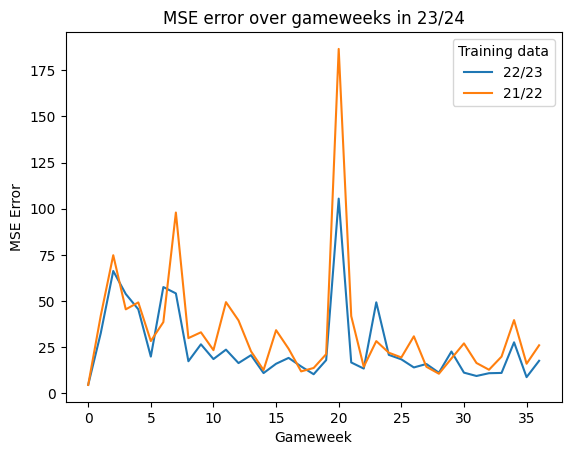

In [ ]:
import matplotlib.pyplot as plt

# Example data
list1 = loss_over_gameweeks_22_23
list2 = loss_over_gameweeks_22_23_alt
# list3 = [0]*37
# list2 = list3

# Plot each list
plt.plot(list1, label='22/23')
plt.plot(list2, label='21/22')
# plt.plot(list3, label='7,14,21,28,35')

# Plot times of re-training
# plt.scatter([10,20,30], [list2[i] for i in [10,20,30]], color='orange', marker='x')
# plt.scatter([7,14,21,28,35], [list3[i] for i in [7,14,21,28,35]], color='green', marker='x')

# Add labels and legend
plt.xlabel('Gameweek')
plt.ylabel('MSE Error')
plt.title('MSE error over gameweeks in 23/24')
plt.legend(title="Training data")

# Show the plot
plt.show()